# DistilBERT classifier for propositions

This DistilBERT implementation follows [Raschka et al. (2022)](https://github.com/rasbt/machine-learning-book)
from pp. 575-586. Here is the corresponding: [code](https://github.com/rasbt/machine-learning-book/blob/main/ch16/ch16-part3-bert.ipynb).

Sebastian Raschka,  Yuxi Liu and Vahid Mirjalili.  2022. Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python. Packt Publishing.

## Settings and imports

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

import os
import sys
PATH = r"/content/gdrive/My Drive/Colab Notebooks/AM_BERT_classification"
os.chdir(PATH)

# Create directory, if it does not exist
os.makedirs("models", exist_ok=True)

# Add the subdirectory to the sys.path
subdirectory_path = os.path.join(os.getcwd(), "scripts")
sys.path.insert(0, subdirectory_path)

Mounted at /content/gdrive


In [ ]:
from corpus_loader import CorpusLoader
from microtext_preprocessor import MicrotextPropositionPrepper

import copy
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR

from transformers import BertForSequenceClassification
from transformers import BertTokenizerFast

from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast

Specifying general settings to make the results reproducible.

In [ ]:
torch.backends.cudnn.deterministic = True
random_seed = 80
torch.manual_seed(random_seed)

available_gpu = torch.cuda.is_available()

if available_gpu:
  print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
  print("GPU not available.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU not available.


## Data

Loading propositions from **Part One** of the [Argumentative Microtext Corpus](https://peldszus.github.io/files/eca2015-preprint.pdf) with custom classes (CorpusLoader, MicrotextPropositionPrepper). The arguments are labeled with three categories:`pro`, `opp`, `None`.

**Terminology**

EDU = elementary discourse unit \
ADU = argumentation discourse unit

**Reference**

Andreas Peldszus and Manfred Stede. An annotated corpus of argumentative
microtexts. In D. Mohammed, and M. Lewinski, editors, Argumentation and
Reasoned Action - Proc. of the 1st European Conference on Argumentation,
Lisbon, 2015. College Publications, London, 2016

The **corpus statistics** as of 24.07.2024 is as follows (calculated with `scripts/microtext_preprocessor.py`):

### Corpus Information Microtext Part One
| Metric                    | Value               |
|---------------------------|---------------------|
| All documents from corpus | 112                 |
| Average EDUs per document | 5.142857142857143   |

### Categories
| Metric                      | Count  |
|-----------------------------|--------|
| Opponent ADUs               | 125    |
| Proponent ADUs              | 451    |
| EDUs without label          | 0      |
| EDUs in sum                 | 576    |

In [ ]:
# The URL for the Microtext Part One as zip file
url_microtext = "https://github.com/peldszus/arg-microtexts/archive/refs/heads/master.zip"
microtext_save_path = "data/corpus_2/"
microtext_path = "data/corpus_2/arg-microtexts-master/corpus/en/"
microtext_file_type_ann = ".xml"
microtext_file_type_text = ".txt"


corpus_loader = CorpusLoader()
propositions = MicrotextPropositionPrepper()

corpus_loader.download_file_from(url_microtext, microtext_save_path)

all_annotation = corpus_loader.load_files_from(microtext_path,
                                               microtext_file_type_ann)
#  Pandas has no deepcopy function for nested elements
copy_annotation = pd.DataFrame(copy.deepcopy(all_annotation.to_dict()))

all_set_part1 = propositions.instance_extraction(copy_annotation)
print(all_set_part1.head())
print(all_set_part1.tail())

Path data/corpus_2/ already exists. Skipping download.
  label                                               text
0   opp  Yes, it's annoying and cumbersome to separate ...
1   opp  Three different bin bags stink away in the kit...
2   pro    But still Germany produces way too much rubbish
3   pro  and too many resources are lost when what actu...
4   pro  We Berliners should take the chance and become...
    label                                               text
571   pro  Time and again children or the elderly slip on...
572   opp  A fine for leaving dog waste behind admittedly...
573   pro  but similar rules are often in place for bicyc...
574   pro   Increasing penalties is therefore the right way.
575   pro  A dog dirt-free city will be more attractive n...


Loading propositions from **Part Two** of the [Argumentative Microtext Corpus](https://aclanthology.org/W18-5218.pdf) with custom classes (CorpusLoader, MicrotextPropositionPrepper). The arguments are labeled with three categories:`pro`, `opp`, `None`.

**Reference**

Maria Skeppstedt, Andreas Peldszus and Manfred Stede. More or less
controlled elicitation of argumentative text: Enlarging a microtext corpus via
crowdsourcing. In Proc. 5th Workshop in Argumentation Mining (at EMNLP),
Brussels, 2018

The **corpus statistics** as of 24.07.2024 is as follows (calculated with `scripts/microtext_preprocessor.py`):

### Corpus Information Microtext Part Two
| Metric                    | Value               |
|---------------------------|---------------------|
| All documents from corpus | 171                 |
| Average EDUs per document | 5.643274853801169   |

### Categories
| Metric                      | Count  |
|-----------------------------|--------|
| Opponent ADUs               | 129    |
| Proponent ADUs              | 832    |
| EDUs without label          | 4      |
| EDUs in sum                 | 965    |

In [ ]:
# The URL for Part Two of the Microtext Part Two as zip file
url_microtext = "https://github.com/discourse-lab/arg-microtexts-part2/archive/refs/heads/master.zip"
microtext_save_path = "data/corpus_3/"
microtext_path = "data/corpus_3/arg-microtexts-part2-master/corpus/"
microtext_file_type_ann = ".xml"
microtext_file_type_text = ".txt"

corpus_loader = CorpusLoader()
propositions = MicrotextPropositionPrepper()

corpus_loader.download_file_from(url_microtext, microtext_save_path)

all_annotation = corpus_loader.load_files_from(microtext_path,
                                               microtext_file_type_ann)
#  Pandas has no deepcopy function for nested elements
copy_annotation = pd.DataFrame(copy.deepcopy(all_annotation.to_dict()))

all_set_part2 = propositions.instance_extraction(copy_annotation)
print(all_set_part2.head())
print(all_set_part2.tail())

Path data/corpus_3/ already exists. Skipping download.
  label                                               text
0   pro                Hunting is good for the environment
1   pro  because overpopulated species can be thinned out.
2   pro  Getting rid of an overpopulation enables the s...
3   pro  It also allows for nature to take back the woo...
4   opp  Some people may object to hunting on the basis...
    label                                               text
960   pro  Large families are not necessarily better for ...
961   pro  Having a larger family causes each member to f...
962   opp  One could argue that with a larger family, the...
963   pro  However, this could also cause disturbances an...
964   pro  Smaller families have the potential to be tigh...


Let us merge the two parts of the extended corpus.

In [ ]:
all_set = pd.concat([all_set_part1, all_set_part2], ignore_index=True)
print(all_set.head())
print(all_set.tail())
print(f"Total of 'opp' propositions {len(all_set[all_set['label'] == 'opp'])}")
print(f"Total of 'pro' propositions {len(all_set[all_set['label'] == 'pro'])}")
print(f"Total of 'None' propositions {len(all_set[all_set['label'] == 'None'])}")


  label                                               text
0   opp  Yes, it's annoying and cumbersome to separate ...
1   opp  Three different bin bags stink away in the kit...
2   pro    But still Germany produces way too much rubbish
3   pro  and too many resources are lost when what actu...
4   pro  We Berliners should take the chance and become...
     label                                               text
1536   pro  Large families are not necessarily better for ...
1537   pro  Having a larger family causes each member to f...
1538   opp  One could argue that with a larger family, the...
1539   pro  However, this could also cause disturbances an...
1540   pro  Smaller families have the potential to be tigh...
Total of 'opp' propositions 254
Total of 'pro' propositions 1283
Total of 'None' propositions 4


In the [annotation guideline of the Microtext Corpus Part Two](https://www.ling.uni-potsdam.de/~stede/Papers/ArgGuidelinesEnglish.pdf), Peldszus et al. (2016) explain that "EDUs and ADUs cannot be assigned to one another 1:1". However, as we can observe, only four of all propositions were labeled as "not an ADU", that is as EDU. For the following training purposes, the category `None` should be deleted to arrive at class sets with greater balance.

**Reference**
A. Peldszus, S. Warzecha, M. Stede: Annotation Guidelines for Argumentation Structure. English translation of chapter “Argumentationsstruktur” in M. Stede (ed.): Handbuch Textannotation – Potsdamer Kommentarkorpus 2.0. Universitätsverlag Potsdam, 2016.

In [ ]:
# Remove instances with the label "None"
all_set = all_set[all_set["label"] != "None"]

Applying numeric labels to training and test set. We are now dealing with a binary classification task.

In [ ]:
label_mapping = {
    "opp": 0,
    "pro": 1
}

all_set["label"] = all_set["label"].map(label_mapping)
print(all_set.head())

   label                                               text
0      0  Yes, it's annoying and cumbersome to separate ...
1      0  Three different bin bags stink away in the kit...
2      1    But still Germany produces way too much rubbish
3      1  and too many resources are lost when what actu...
4      1  We Berliners should take the chance and become...


Splitting the training set into **training**, **validation**, and **test** sets: We aim for a 70:10:20 split. Another reason for dropping `None`instances is that the class would not be large enough to properly stratisfy the labels for the splits.

In [ ]:
X = all_set["text"]
y = all_set["label"]


X_train, X_split, y_train, y_split = train_test_split(X, y,
                                                      test_size=0.3,
                                                      random_state=random_seed,
                                                      stratify=y)

# To arrive at a validation set that consists of 10% of overall datapoints
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split,
                                                    test_size=0.6666,
                                                    random_state=random_seed,
                                                    stratify=y_split)

X_train = X_train.values  # PyTorch tokenizer can handle lists or strings
X_valid = X_valid.values
X_test = X_test.values
y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(X_train[0])
print(y_train[0])

(1075,)
(154,)
(308,)
as the driver ends up using just one hand instead of both hands on the steering wheel.
1


## Data preparation

Tokenizing the dataset with the tokenizer taken from the pre-trained model
class. The advantage of using the inherited tokenizer is that "the consistency
between the pre-trained model and the dataset" is maintained
(Raschka 2022, p. 577)


The tokenizer can create a schema that resembles the following structure:

> [CLS] Proposition 1 [SEP][PAD] [PAD] ...

Where [CLS] and [SEP] are special tokens used for telling the BERT model where propositions start and end. [PAD] is used for padding so that each sample is of equal size.

In [ ]:
"""tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
    )
"""

tokenizer = BertTokenizerFast.from_pretrained(
    "bert-base-uncased"
    )

train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
valid_encodings = tokenizer(list(X_valid), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Let's visualize the tokenized instances with corresponding ids and masks.

In [ ]:
for i in range(3):
    print(f"input_ids: {train_encodings['input_ids'][i]}")
    print(f"attention_mask: {train_encodings['attention_mask'][i]}")
    print(f"sentence: {tokenizer.decode(train_encodings['input_ids'][i])}")

input_ids: [101, 2004, 1996, 4062, 4515, 2039, 2478, 2074, 2028, 2192, 2612, 1997, 2119, 2398, 2006, 1996, 9602, 5217, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sentence: [CLS] as the driver ends up using just one hand instead of both hands on the steering wheel. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

A self-defined data class helps with customizing all related features and functions.

In [ ]:
class CDCPDataset(torch.utils.data.Dataset):
    """
    Self-defined data class to customize features by changing some magic
    methods. __getitem__ only extraxts the most relevant information from the
    encodings.

    Cf. Raschka et al. (2022, p. 577-8)
    """

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx])
                for key, val in self.encodings.items()}
        item["label"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Creating PyTorch Dataloaders:

The data was already shuffled with the splits.

Shuffling the data stabilizes the training process and can potentially enhance the model's final performance. Principally, it only needs to be applied to the training set. The metrics calculated for the validation and test sets will remain the same regardless of the data order.

In [ ]:
train_dataset = CDCPDataset(train_encodings, y_train)
valid_dataset = CDCPDataset(valid_encodings, y_valid)
test_dataset = CDCPDataset(test_encodings, y_test)

batch_size = 128  # Slight boost for T4 GPU if batch size is 128

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=False
)


## Fine-tuning the model

### [BERT](https://huggingface.co/google-bert/bert-base-uncased)
BERT is a transformer model that has been pretrained on a vast collection of English texts using a self-supervised approach. The ***BertForSequenceClassification*** version is designed for sequence classification. It includes a classification head on top of the pooled output, specifically for tasks like sentiment analysis, spam detection, etc. When we instantiate BertForSequenceClassification, the loss function used is `CrossEntropyLoss`. Passing the labels along with the input to the model is sufficient, the Hugging Face library automatically computes the loss if the labels are provided.

### [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased):

The DistilBERT base uncased model can also be used as it is faster, lighter, and smaller than BERT [(Sanh et al. 2019)](https://arxiv.org/abs/1910.01108), but reaches performance results close to BERT.

In [ ]:
"""
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased"
)
"""
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased"
)
model_name = f"models/Bert_proposition_micro_class1_3.pt"
model.to(device)
model.train()

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = LinearLR(optimizer,
                     start_factor=1.0,
                     end_factor=0.3,
                     total_iters=10)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy function to evaluate the model:

In [ ]:
def compute_accuracy(model, data_loader, device):
    """
    Cf. Raschka et al. (2022, p. 579)
    """
    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            # Prepare data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            predicted_labels = torch.argmax(logits, dim=1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()

        return correct_pred.float()/num_examples * 100

F1 function to evaluate the model:

In [ ]:
def compute_f1_scores(model, data_loader, device):
    with torch.no_grad():

        all_labels = []
        all_predictions = []

        for batch_idx, batch in enumerate(data_loader):

            # Prepare data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            predicted_labels = torch.argmax(logits, dim=1)

            # If the tensors are on the GPU, .cpu() moves them to the CPU.
            # This step is necessary because the numpy() method is not supported
            # on GPU tensors.
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

        # Create a report dictionary
        report = classification_report(all_labels,
                                       all_predictions,
                                       output_dict=True)


        return report

Function to evaluate loss:

In [ ]:
def compute_loss(model, data_loader, device):
    # Dropout is disabled and batch normalization uses the learned statistics
    # instead of the statistics of the current batch.
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):

            # Prepare data
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss, logits = outputs["loss"], outputs["logits"]

            running_loss += loss.item()

    final_loss = running_loss/ len(data_loader)

    return final_loss


### Training:

This is the training loop for finetuning the model. After some manual tests with DistilBERT, five epochs are sufficient for the model to converge for the given task.

In [ ]:
start_time = time.time()
num_epochs = 5

train_acc_history = [0] * num_epochs
valid_acc_history = [0] * num_epochs

train_loss_history = [0] * num_epochs
valid_loss_history = [0] * num_epochs

# Cf. Raschka et al. (2022, p. 580-1)
for epoch in range(num_epochs):

    model.train()
    running_train_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):

        # Prepare data
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss, logits = outputs["loss"], outputs["logits"]

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Scheduler step
        scheduler.step()

        # Logging
        if not batch_idx % 10:
            print(f"Epoch: {epoch+1:04d}/{num_epochs:04d}"
                  f" | Batch "
                  f"{batch_idx:04d}/"
                  f"{len(train_loader):04d} | "
                  f"Loss: {loss:.4f}")

    train_loss = running_train_loss / len(train_loader)
    valid_loss = compute_loss(model, valid_loader, device)

    train_loss_history[epoch] = train_loss
    valid_loss_history[epoch] = valid_loss

    print(f"Epoch: {epoch+1}/{num_epochs} | "
          f"Training Loss: {train_loss:.4f} | "
          f"Validation Loss: {valid_loss:.4f}")

    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, device)
        valid_acc = compute_accuracy(model, valid_loader, device)
        print(f"Training accuracy: "
              f"{train_acc:.2f}%"
              f"\nValidation accuracy: "
              f"{valid_acc:.2f}%"
              )

    train_acc_history[epoch] = train_acc
    valid_acc_history[epoch] = valid_acc

# Evaluate and save model
model.eval()
torch.save(model.state_dict(), model_name)

print(f"Time elapsed: {(time.time() - start_time)/60:.2f} min")

Epoch: 0001/0005 | Batch 0000/0009 | Loss: 0.7359
Epoch: 1/5 | Training Loss: 0.4906 | Validation Loss: 0.4766
Training accuracy: 83.44%
Validation accuracy: 83.77%
Epoch: 0002/0005 | Batch 0000/0009 | Loss: 0.4065
Epoch: 2/5 | Training Loss: 0.4312 | Validation Loss: 0.4330
Training accuracy: 85.21%
Validation accuracy: 84.42%
Epoch: 0003/0005 | Batch 0000/0009 | Loss: 0.4242
Epoch: 3/5 | Training Loss: 0.3711 | Validation Loss: 0.3840
Training accuracy: 88.84%
Validation accuracy: 81.17%
Epoch: 0004/0005 | Batch 0000/0009 | Loss: 0.2893
Epoch: 4/5 | Training Loss: 0.3239 | Validation Loss: 0.3742
Training accuracy: 90.23%
Validation accuracy: 81.82%
Epoch: 0005/0005 | Batch 0000/0009 | Loss: 0.2866
Epoch: 5/5 | Training Loss: 0.2974 | Validation Loss: 0.3366
Training accuracy: 93.58%
Validation accuracy: 83.77%
Time elapsed: 0.68 min


## Evaluation

Visualizing accuracy during training with Matplotlib.

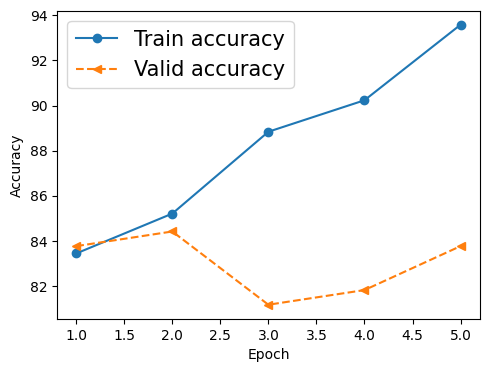

In [ ]:
x_arr = np.arange(len(train_acc_history)) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, [e.cpu() for e in train_acc_history],
        "-o",
        label="Train accuracy")
ax.plot(x_arr, [e.cpu() for e in valid_acc_history],
        "--<",
        label="Valid accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(fontsize=15)

Visualizing loss during training with Matplotlib.


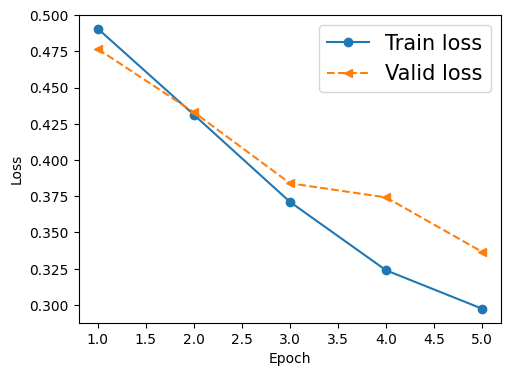

In [ ]:
x_arr = np.arange(len(train_loss_history)) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, train_loss_history, "-o", label="Train loss")
ax.plot(x_arr, valid_loss_history, "--<", label="Valid loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(fontsize=15)

# Metrics:

To report a full range of metrics, we can use the customized `compute_f1_scores`. The function returns `precision`, `recall`, `accuracy`, `macro F1` and `weighted F1` scores. For an imbalanced distribution of classes, it is reasonable to consider the weighted F1 score because it takes the support count for each class into account.

Macro F1 := Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

Micro F1 / weighted average := Calculate metrics globally by counting the total true positives false negatives and false positives.

In [ ]:
if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_name))
else:
    model.load_state_dict(torch.load(model_name,
                                     map_location=torch.device("cpu")))

report = compute_f1_scores(model, test_loader, device)
print(f"Test score: {report}")

Test scores: {'0': {'precision': 0.8, 'recall': 0.39215686274509803, 'f1-score': 0.5263157894736842, 'support': 51.0}, '1': {'precision': 0.8904593639575972, 'recall': 0.980544747081712, 'f1-score': 0.9333333333333333, 'support': 257.0}, 'accuracy': 0.8831168831168831, 'macro avg': {'precision': 0.8452296819787986, 'recall': 0.686350804913405, 'f1-score': 0.7298245614035088, 'support': 308.0}, 'weighted avg': {'precision': 0.8754807030425406, 'recall': 0.8831168831168831, 'f1-score': 0.8659375712007292, 'support': 308.0}}


Finally, we can log the results at `results/log.json`.

In [ ]:
file_path = "results/log.json"

try:
    with open(file_path, "r") as file:
        data = json.load(file)
except FileNotFoundError:
    data = {}
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

data[model_name] = report

with open(file_path, "w") as file:
    json.dump(data, file, indent=4)

print(f"Updated data written to {file_path}.")

Updated data written to results/log.json
